In [35]:
import torch
import pickle
from transformers import BertTokenizer
import torch.nn as nn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from warnings import filterwarnings
filterwarnings("ignore")
# Load label encoder
with open(r"E:\Thesis NLP\label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("saved_tokenizer")

# Recreate your custom classifier class (must match training)
class BERTClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        from transformers import BertModel  # local import to avoid ordering issues
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.bert.config.hidden_size, len(label_encoder.classes_))
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        cls_output = self.dropout(cls_output)
        return self.linear(cls_output)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load fine-tuned BERT model weights
bert_model = BERTClassifier().to(device)
bert_model.load_state_dict(torch.load("bert_classifier_state_dict.pth", map_location=device))
bert_model.eval()


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: b480587c-2879-4713-a97f-ff980c0b71c2)')' thrown while requesting HEAD https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json
Retrying in 1s [Retry 1/5].


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [36]:
# Encode labels in df
import pandas as pd
df = pd.read_pickle(r"E:\Thesis NLP\preprocessed_comments.pkl")

df = df.copy()
df['encoded_Severity_Level'] = label_encoder.transform(df['Severity Level'])

X = df['cleaned_sentence'].tolist()
y = df['encoded_Severity_Level'].values

# Stratified split: 70% train, 15% val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.17647, stratify=y_temp, random_state=42)
# 0.17647 makes validation ~15% overall

print(f"Sizes -> train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")


Sizes -> train: 1988, val: 426, test: 427


In [37]:

def get_bert_probs(texts, batch_size=16):
    bert_model.eval()
    all_probs = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            tokens = tokenizer(batch_texts,
                               return_tensors="pt",
                               padding=True,
                               truncation=True,
                               max_length=64)
            inputs = {k: v.to(device) for k, v in tokens.items()}
            logits = bert_model(**inputs)  # (batch, num_classes)
            probs = torch.softmax(logits, dim=1)  # (batch, num_classes)
            all_probs.append(probs.cpu().numpy())
    return np.vstack(all_probs)

bert_train_probs = get_bert_probs(X_train)
bert_val_probs   = get_bert_probs(X_val)
bert_test_probs  = get_bert_probs(X_test)

print("Shapes:", bert_train_probs.shape, bert_val_probs.shape, bert_test_probs.shape)

Shapes: (1988, 2) (426, 2) (427, 2)


In [38]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.metrics import accuracy_score

# ---- Build vocab from X_train ----
def build_vocab(texts, max_vocab=8000, min_freq=2):
    counter = Counter()
    for t in texts:
        counter.update(t.split())
    vocab = {"<PAD>": 0, "<UNK>": 1}
    idx = 2
    for word, freq in counter.most_common():
        if freq < min_freq or len(vocab) >= max_vocab:
            continue
        if word in vocab:
            continue
        vocab[word] = idx
        idx += 1
    return vocab

vocab = build_vocab(X_train, max_vocab=8000, min_freq=2)
pad_idx = vocab["<PAD>"]

# ---- Sequence encoding ----
def encode_sequence(text, vocab, max_len=50):
    tokens = text.split()
    ids = [vocab.get(w, vocab["<UNK>"]) for w in tokens]
    if len(ids) < max_len:
        ids = ids + [pad_idx] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

class SeqDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=50):
        self.seqs = [encode_sequence(t, vocab, max_len) for t in texts]
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.seqs[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# ---- DataLoaders ----
seq_max_len = 50
batch_size = 64

train_seq_ds = SeqDataset(X_train, y_train, vocab, max_len=seq_max_len)
val_seq_ds = SeqDataset(X_val, y_val, vocab, max_len=seq_max_len)
test_seq_ds = SeqDataset(X_test, y_test, vocab, max_len=seq_max_len)

train_seq_loader = DataLoader(train_seq_ds, batch_size=batch_size, shuffle=True)
val_seq_loader = DataLoader(val_seq_ds, batch_size=batch_size)
test_seq_loader = DataLoader(test_seq_ds, batch_size=batch_size)

# ---- LSTM model ----
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    def forward(self, x):
        emb = self.embedding(x)                     # (B, L, E)
        out, _ = self.lstm(emb)                    # (B, L, H*2)
        pooled = out[:, 0, :]                      # first timestep (alternatively mean/max)
        dropped = self.dropout(pooled)
        return self.fc(dropped)

lstm_model = LSTMClassifier(vocab_size=len(vocab), num_classes=len(label_encoder.classes_)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)

# ---- Train LSTM ----
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    return acc, np.array(all_preds), np.array(all_labels)

epochs = 10
for epoch in range(1, epochs+1):
    loss = train_epoch(lstm_model, train_seq_loader)
    val_acc, _, _ = evaluate(lstm_model, val_seq_loader)
    print(f"[LSTM] Epoch {epoch} loss={loss:.4f} val_acc={val_acc:.4f}")

# ---- Get LSTM probabilities for stacking ----
def get_lstm_probs(model, loader):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            all_probs.append(probs.cpu().numpy())
    return np.vstack(all_probs)

lstm_val_probs = get_lstm_probs(lstm_model, val_seq_loader)
lstm_test_probs = get_lstm_probs(lstm_model, test_seq_loader)


[LSTM] Epoch 1 loss=18.8243 val_acc=0.7136
[LSTM] Epoch 2 loss=14.4860 val_acc=0.7911
[LSTM] Epoch 3 loss=11.7879 val_acc=0.8169
[LSTM] Epoch 4 loss=9.6866 val_acc=0.8263
[LSTM] Epoch 5 loss=7.8196 val_acc=0.8239
[LSTM] Epoch 6 loss=5.9615 val_acc=0.8146
[LSTM] Epoch 7 loss=4.9911 val_acc=0.8099
[LSTM] Epoch 8 loss=4.6826 val_acc=0.8263
[LSTM] Epoch 9 loss=2.9296 val_acc=0.8310
[LSTM] Epoch 10 loss=1.9612 val_acc=0.8263


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ---- Random Forest on TF-IDF ----
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_tfidf, y_train)

rf_val_probs  = rf.predict_proba(X_val_tfidf)
rf_test_probs = rf.predict_proba(X_test_tfidf)

# ---- Step 5: Stack (meta-learner) ----
# Concatenate probabilities from BERT, LSTM, and RF for validation and test
meta_X_val  = np.hstack([bert_val_probs, lstm_val_probs, rf_val_probs])
meta_y_val  = y_val
meta_X_test = np.hstack([bert_test_probs, lstm_test_probs, rf_test_probs])
meta_y_test = y_test

# Train logistic regression as meta-learner
meta_clf = LogisticRegression(max_iter=1000)
meta_clf.fit(meta_X_val, meta_y_val)

# Ensemble prediction
meta_test_preds = meta_clf.predict(meta_X_test)

# Evaluation
print("=== Stacked Ensemble Results ===")
print("Accuracy:", accuracy_score(meta_y_test, meta_test_preds))
print(classification_report(meta_y_test, meta_test_preds, target_names=label_encoder.classes_))
print("Confusion Matrix:\n", confusion_matrix(meta_y_test, meta_test_preds))

# ---- Optional: compare base models ----
bert_test_preds = np.argmax(bert_test_probs, axis=1)
lstm_test_preds = np.argmax(lstm_test_probs, axis=1)
rf_test_preds   = rf.predict(X_test_tfidf)

print("\n-- Base Model Performance --")
print("BERT:", classification_report(meta_y_test, bert_test_preds, target_names=label_encoder.classes_))
print("LSTM:", classification_report(meta_y_test, lstm_test_preds, target_names=label_encoder.classes_))
print("RandomForest:", classification_report(meta_y_test, rf_test_preds, target_names=label_encoder.classes_))


=== Stacked Ensemble Results ===
Accuracy: 0.9578454332552693
               precision    recall  f1-score   support

    Depressed       0.95      0.96      0.96       212
Not Depressed       0.96      0.95      0.96       215

     accuracy                           0.96       427
    macro avg       0.96      0.96      0.96       427
 weighted avg       0.96      0.96      0.96       427

Confusion Matrix:
 [[204   8]
 [ 10 205]]

-- Base Model Performance --
BERT:                precision    recall  f1-score   support

    Depressed       0.94      0.97      0.96       212
Not Depressed       0.97      0.94      0.96       215

     accuracy                           0.96       427
    macro avg       0.96      0.96      0.96       427
 weighted avg       0.96      0.96      0.96       427

LSTM:                precision    recall  f1-score   support

    Depressed       0.80      0.82      0.81       212
Not Depressed       0.82      0.80      0.81       215

     accuracy        

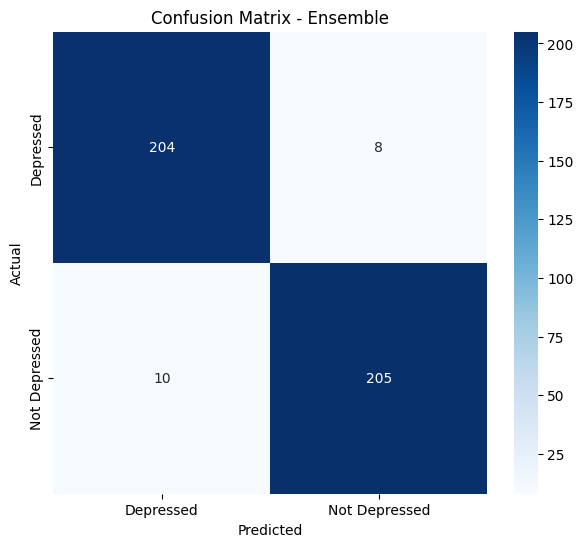

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(meta_y_test, meta_test_preds)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Ensemble')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [41]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(meta_y_test, meta_test_preds, target_names=label_encoder.classes_, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

,precision,recall,f1-score,support
Depressed,0.953271,0.962264,0.957746,212.000000
Not Depressed,0.962441,0.953488,0.957944,215.000000
accuracy,0.957845,0.957845,0.957845,0.957845
macro avg,0.957856,0.957876,0.957845,427.000000
weighted avg,0.957888,0.957845,0.957846,427.000000


Number of classes: 2
Class names: ['Depressed' 'Not Depressed']


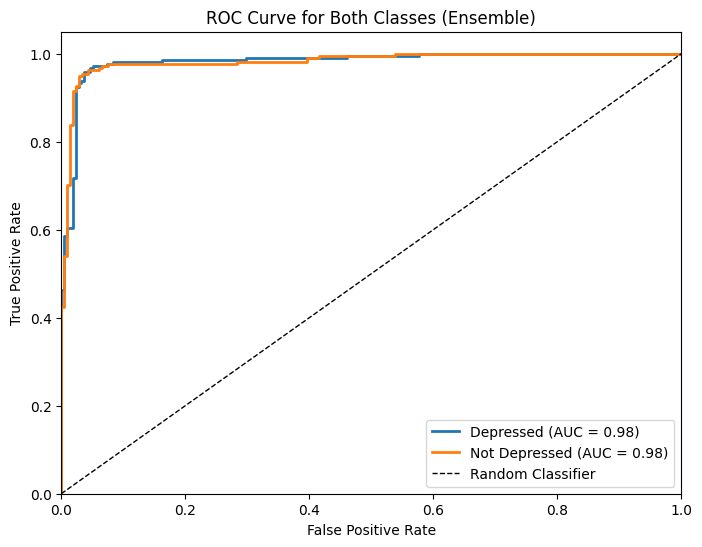

Class distribution in test set:
  Depressed: 212 samples
  Not Depressed: 215 samples


In [42]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

n_classes = len(label_encoder.classes_)
ensemble_probs = meta_clf.predict_proba(meta_X_test)

print(f"Number of classes: {n_classes}")
print(f"Class names: {label_encoder.classes_}")

# For binary classification
if n_classes == 2:
    plt.figure(figsize=(8,6))
    
    # Plot ROC curve for each class
    for i in range(n_classes):
        # Create binary labels for current class vs rest
        y_binary = (np.array(meta_y_test) == i).astype(int)
        
        # Get probabilities for current class
        class_probs = ensemble_probs[:, i]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_binary, class_probs)
        roc_auc = auc(fpr, tpr)
        
        # Plot the curve
        plt.plot(fpr, tpr, lw=2, 
                label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')
    
    # Add random classifier line
    plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Both Classes (Ensemble)')
    plt.legend(loc="lower right")
    plt.show()
    
    # Print class distribution
    unique, counts = np.unique(meta_y_test, return_counts=True)
    print(f"Class distribution in test set:")
    for i, (class_idx, count) in enumerate(zip(unique, counts)):
        print(f"  {label_encoder.classes_[class_idx]}: {count} samples")
        
else:
    # For multi-class classification
    y_true_bin = label_binarize(meta_y_test, classes=range(n_classes))

    # Plot ROC curve for each class
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], ensemble_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve by Class (Ensemble)')
    plt.legend(loc="lower right")
    plt.show()

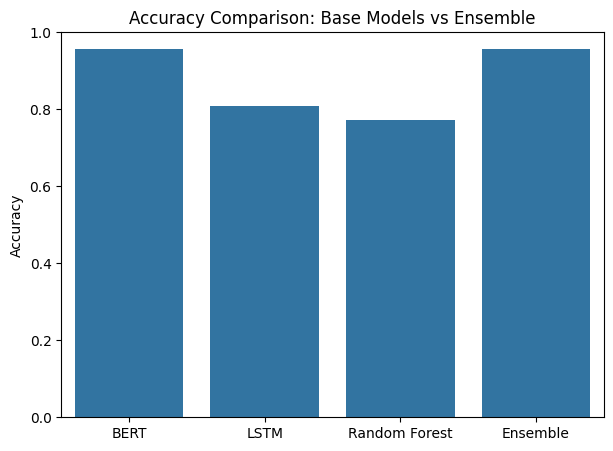

In [43]:
base_accuracies = [
    accuracy_score(meta_y_test, bert_test_preds),
    accuracy_score(meta_y_test, lstm_test_preds),
    accuracy_score(meta_y_test, rf_test_preds),
    accuracy_score(meta_y_test, meta_test_preds)
]
labels = ['BERT', 'LSTM', 'Random Forest', 'Ensemble']

plt.figure(figsize=(7,5))
sns.barplot(x=labels, y=base_accuracies)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Base Models vs Ensemble')
plt.show()

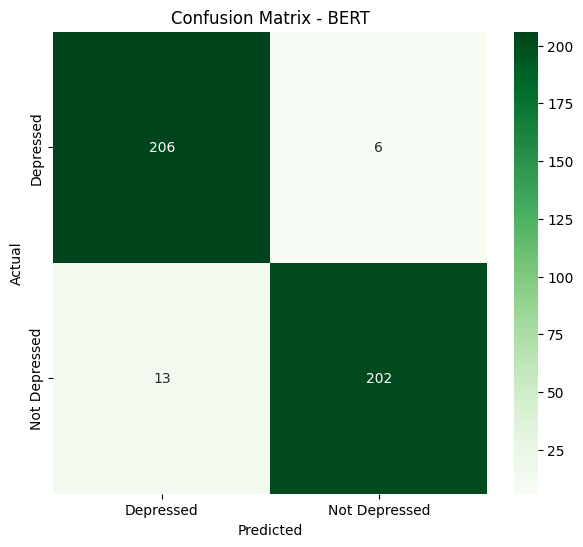

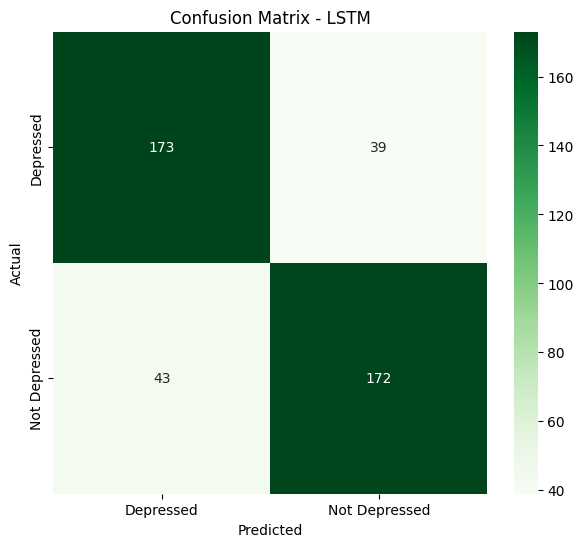

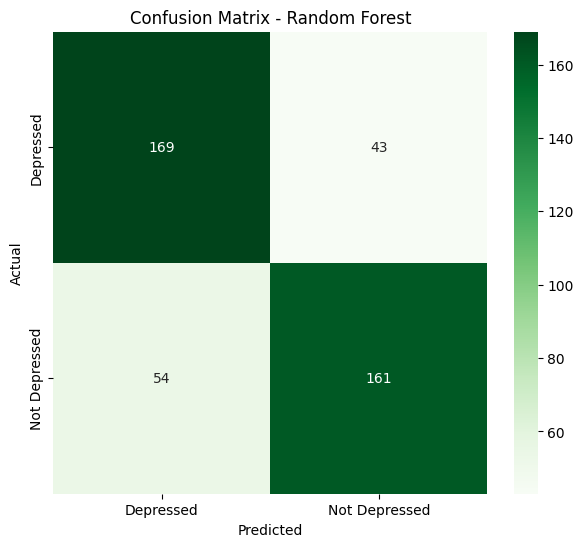

In [44]:
for name, preds in zip(['BERT', 'LSTM', 'Random Forest'],
                       [bert_test_preds, lstm_test_preds, rf_test_preds]):
    cm = confusion_matrix(meta_y_test, preds)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

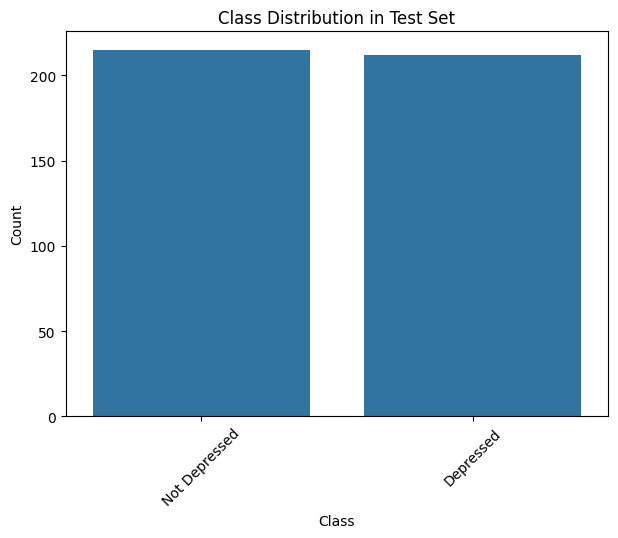

In [45]:
plt.figure(figsize=(7,5))
sns.countplot(x=[label_encoder.classes_[i] for i in meta_y_test])
plt.title('Class Distribution in Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

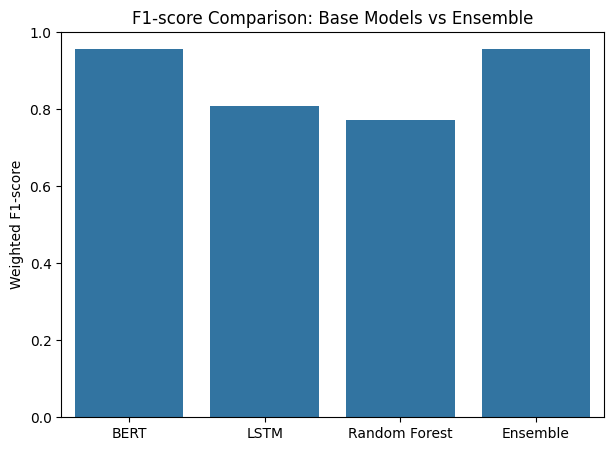

In [46]:
from sklearn.metrics import f1_score

f1s = [
    f1_score(meta_y_test, bert_test_preds, average='weighted'),
    f1_score(meta_y_test, lstm_test_preds, average='weighted'),
    f1_score(meta_y_test, rf_test_preds, average='weighted'),
    f1_score(meta_y_test, meta_test_preds, average='weighted')
]
plt.figure(figsize=(7,5))
sns.barplot(x=labels, y=f1s)
plt.ylim(0, 1)
plt.ylabel('Weighted F1-score')
plt.title('F1-score Comparison: Base Models vs Ensemble')
plt.show()

In [47]:
import joblib

# Save the meta-learner (ensemble model)
joblib.dump(meta_clf, "ensemble_meta_clf.joblib")

print("Ensemble meta-classifier saved to ensemble_meta_clf.joblib")

Ensemble meta-classifier saved to ensemble_meta_clf.joblib


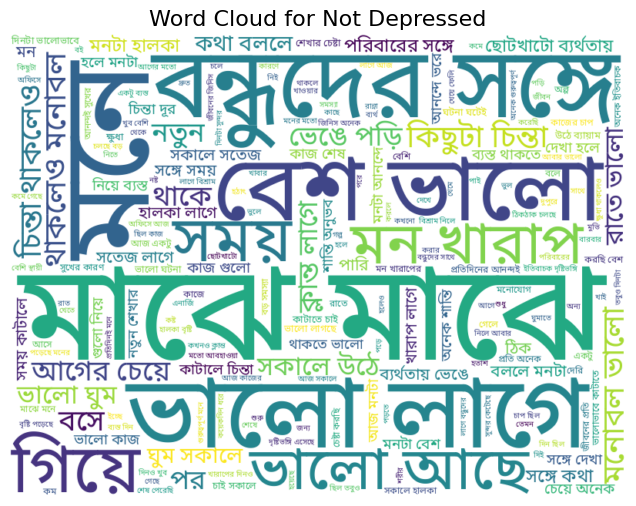

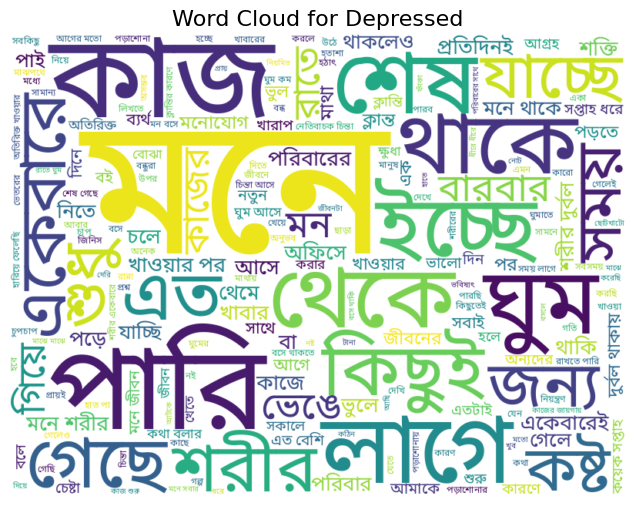

In [50]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Load dataset
df = pd.read_csv("PHQ-9 NLP Dataset Collection.csv")

# Bangla stopwords
bangla_stopwords = set([
    'আমি', 'আমার', 'নিজের', 'নিজেকে', 'তুমি', 'সে', 'তারা', 'যে', 'যায়', 'যাই', 'হয়', 'হয়ে', 
    'করে', 'করতে', 'করি', 'করেন', 'না', 'নেই', 'এবং', 'এই', 'ও', 'আর', 'এখন', 'কিন্তু', 
    'তবে', 'তাতে', 'তোমার', 'তাদের', 'যদি', 'তাহলে', 'যখন', 'যেখানে', 'যার', 'যাদের', 
    'সব', 'কিছু', 'একটা', 'একটি', 'কোনো', 'কেন', 'কেমন', 'যেমন', 'কোথায়', 'কি', 'কী', 
    'যা', 'যে', 'তাই', 'তাও', 'তো', 'এর', 'এরপর', 'এরকম', 'এইসব','ছোট', 'প্রতিদিন'
])

# ✅ Properly clean Bangla sentences
def clean_bangla_text(text):
    text = str(text)
    text = re.sub(r'[^\u0980-\u09FF\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Cleaned'] = df['Sentence'].apply(clean_bangla_text)

# ✅ Custom Bangla tokenizer that preserves full words
def bangla_tokenizer(text):
    # Split based on space — not characters
    words = text.split(' ')
    # Filter out stopwords and empty tokens
    words = [w.strip() for w in words if w and w not in bangla_stopwords]
    return words

# Combine texts by severity level
severity_levels = df['Severity Level'].unique()

for level in severity_levels:
    texts = df[df['Severity Level'] == level]['Cleaned']
    
    # Tokenize and rebuild sentence from words
    tokens = []
    for t in texts:
        tokens.extend(bangla_tokenizer(t))
    joined_text = ' '.join(tokens)
    
    # Generate Bangla word cloud
    wc = WordCloud(
        font_path='NotoSansBengali-Regular.ttf',  # Bangla-supported font required
        background_color='white',
        width=800,
        height=600,
        regexp=r'[\u0980-\u09FF]+',  # ✅ ensures whole Bangla words are matched
    ).generate(joined_text)
    
    plt.figure(figsize=(8,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {level}", fontsize=16)
    plt.show()
